# Exercise 2: Diagnostic Checks for SBI 🔍

**Time:** 20 minutes  
**Difficulty:** Intermediate  

In this exercise, you'll learn how to validate your neural posterior estimator using diagnostic tools. These checks are crucial for building trust in your inference results.

## 🎯 Learning Objectives

By the end of this exercise, you will be able to:

1. ✅ Perform prior predictive checks to validate your prior
2. ✅ Monitor neural network training with loss curves
3. ✅ Run posterior predictive checks to validate inference
4. ✅ Use simulation-based calibration (SBC) to test the inference method
5. ✅ Interpret diagnostic results and identify problems

## 📖 The Story Continues...

Your initial analysis of the wolf-deer populations impressed the environmental agency! However, before they implement costly interventions based on your predictions, the senior ecologist asks:

*"How do we know the neural network learned correctly? What if it's just memorizing patterns rather than understanding the true dynamics? These predictions will inform important decisions about hunting quotas and conservation efforts."*

Excellent question! Let's verify our results with diagnostic tools.

## Step 1: Setup and Quick Inference Recap

Let's quickly repeat the inference from Exercise 1 (with fewer simulations for speed):

In [1]:
# Imports
from functools import partial
import matplotlib.pyplot as plt
import pickle
from sbi import utils as utils
from sbi.diagnostics import run_sbc
from sbi.inference import simulate_for_sbi

# Our simulator
from simulators.lotka_volterra import (
    create_lotka_volterra_prior,
    generate_observed_data,
    get_lv_summary_stats_names,
    lotka_volterra_simulator,
)

# Import our utility functions
from utils import plot_predictive_check, plot_training_diagnostics

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 16

/Users/janteusen/qode/euroscipy-2025-sbi-tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup
USE_AUTOCORRELATION = True
prior = create_lotka_volterra_prior()
observed_data, true_params = generate_observed_data(
    use_autocorrelation=USE_AUTOCORRELATION
)
lotka_volterra_simulator = partial(
    lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION
)
# TODO: Adjust number of workers based on your system.
num_workers: int = 5

# Let's load the inference object from exercise 01
filename = f"lv_inference{'_autocorr' if USE_AUTOCORRELATION else ''}.pt"
with open(filename, "rb") as handle:
    npe = pickle.load(handle)

# And build a new posterior object
posterior = npe.build_posterior(prior=prior)
# Set default x to observed data
posterior.set_default_x(observed_data)

print("\n✅ Inference loaded! Now let's check if we can trust it...")


✅ Inference loaded! Now let's check if we can trust it...


## Step 2: Prior Predictive Check

**Key Question:** *Does our observed data fall within the range of data that the prior can generate?*

Before looking at the posterior, we should check if our prior is reasonable:
1. Sample parameters from the prior
2. Simulate data with those parameters  
3. Check if observed data falls within this distribution

If the observed data is far outside the prior predictive distribution, we may need to reconsider our prior.

🔍 Diagnostic 1: Prior Predictive Check
Checking if our observed data is consistent with the prior...



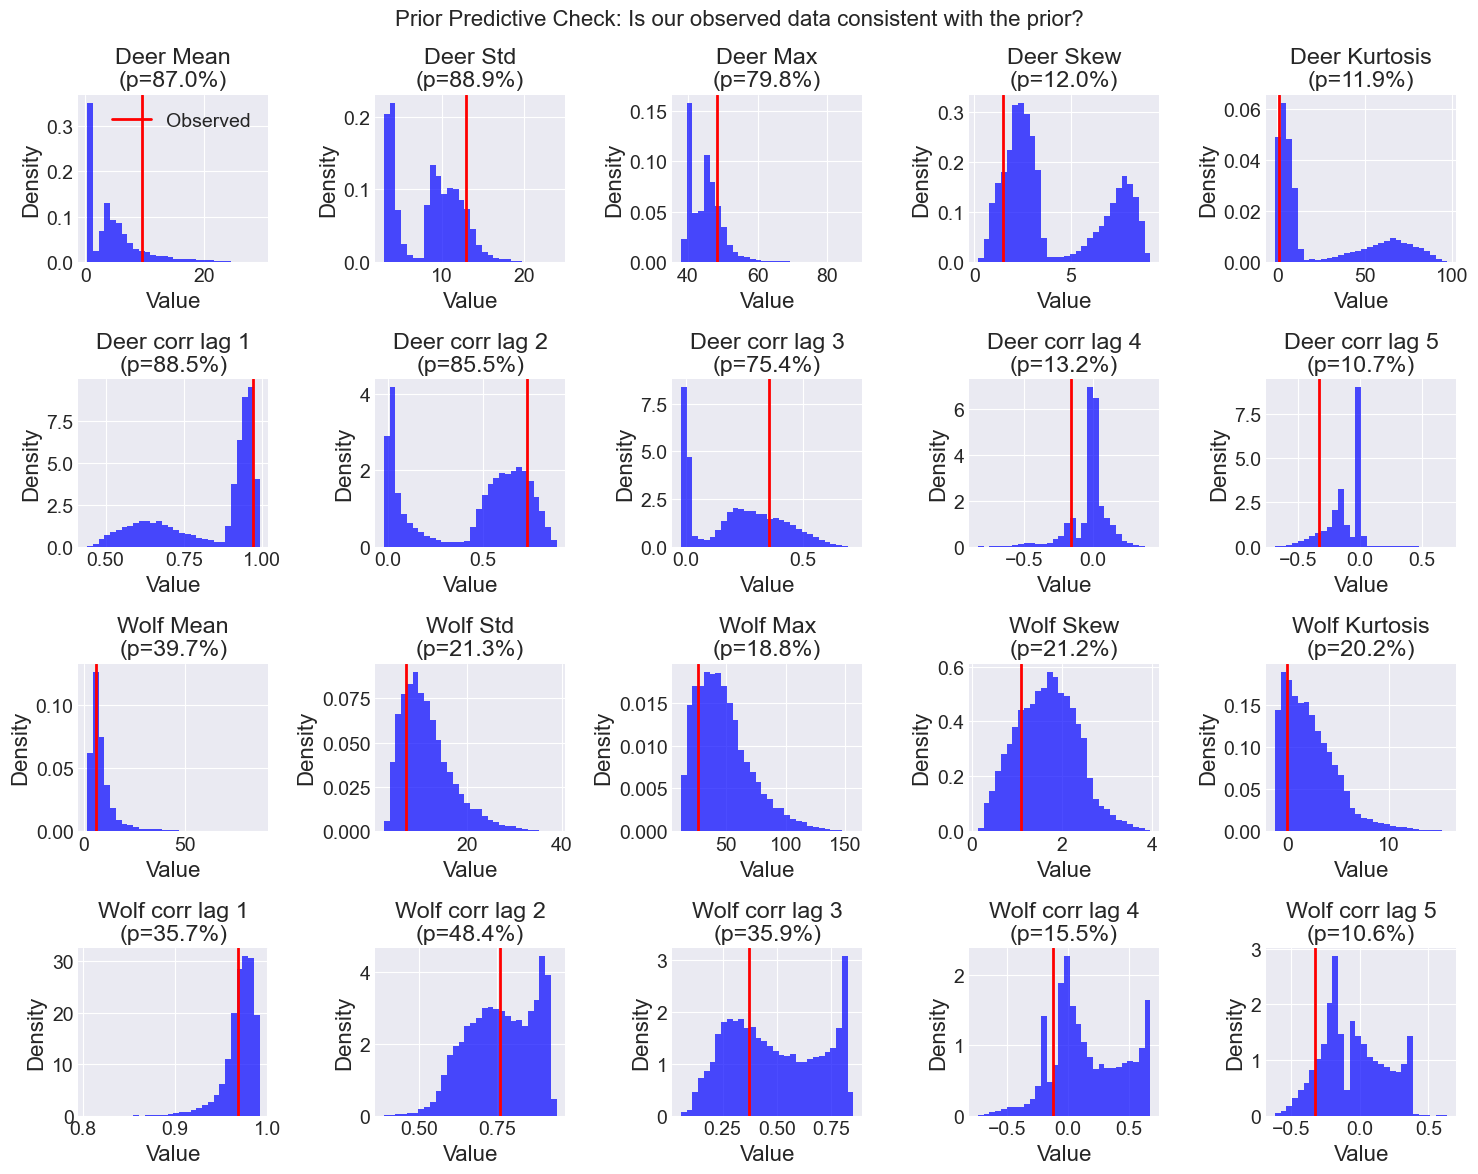


📊 Predictive Check Assessment:
----------------------------------------
✅ PASS: All observed statistics fall well within the predictive distribution.


In [3]:
print("🔍 Diagnostic 1: Prior Predictive Check")
print("=" * 50)
print("Checking if our observed data is consistent with the prior...\n")

# Define the statistics names for the Lotka-Volterra model
stat_names = get_lv_summary_stats_names(USE_AUTOCORRELATION)

# Simulate data from the prior
# theta, x = simulate_for_sbi(lotka_volterra_simulator, prior, num_simulations=10000, num_workers=num_workers)
x = npe._x_roundwise[0]
prior_data_limits: list[tuple[float, float]] = [
    (x.min(dim=0).values[i], x.max(dim=0).values[i]) for i in range(x.shape[1])
]

# Run the prior predictive check using our reusable function
plot_predictive_check(
    x=x,
    observed_data=observed_data,
    stat_names=stat_names,
    title="Prior Predictive Check: Is our observed data consistent with the prior?",
);

## Step 3: Neural Network Training Diagnostics

**Key Question:** *Did the neural network converge during training?*

We need to check if the neural density estimator was trained properly:
- Training loss should decrease and stabilize
- Validation loss should not increase (no overfitting)
- Both loss curves should ideally converge to a plateaux

The `NPE` trainer class saves training and validation loss as well as other statistics
during training. 

🔍 Neural Network Training Diagnostics
Checking if the neural network converged properly...



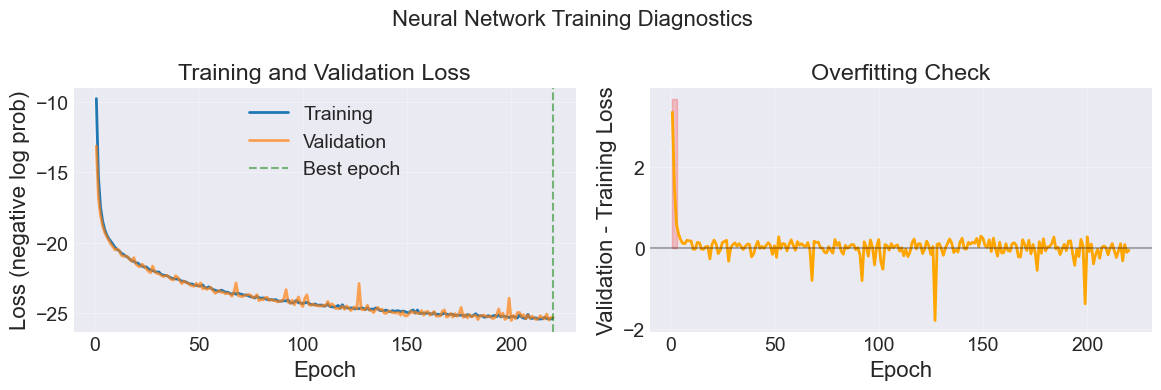


📊 Training Assessment:
----------------------------------------
Final training loss: -25.346
Final validation loss: -25.295
Relative overfitting metric: 0.2%
✅ PASS: No signs of overfitting.
Loss coefficient of variation (last 44 epochs): 0.4%
✅ Training converged (stable loss).


In [4]:
# We can just pass the npe object to our plotting function.
plot_training_diagnostics(npe)

## 🧠 Exercise: Posterior Predictive Check

**Your Task:** Now it's your turn! Apply what you learned from the prior predictive checks to validate the posterior.

**Key Question:** *If we simulate data using parameters from our posterior, does it look
like our observed data (summary statistics)?*

This is the most intuitive diagnostic:
1. Sample parameters from the **posterior** (not the prior!)
2. Simulate data with those parameters
3. Compare simulated data to observations

**💡 Hints:**
- Look back at the prior predictive check code (cell 8) for inspiration
- You'll need to use `simulate_for_sbi()` with the `posterior` instead of the `prior`
- To compare to the prior predictive, you can pass the `prior_data_limits` to maintain consistent axes
- Use a descriptive title like "Posterior Predictive Check: ..."

**🤔 Questions to Answer:**
- Does the predictive data from the posterior cluster around the observed data?
- How does it compare to the prior predictive data from earlier?
- Are the posterior predictions more concentrated than the prior predictions?

In [5]:
# TODO: Your turn! Implement posterior predictive checks
#
# Step 1: Use simulate_for_sbi to generate data from the posterior
# Hint: Look at cell 8 where we did this for the prior
# You'll need: simulate_for_sbi(simulator, distribution, num_simulations, num_workers)
# Remember: use 'posterior' instead of 'prior'

# TODO: Replace this comment with your code
# _, predictive_sims = simulate_for_sbi(...)

# Uncomment and complete the line below:
# _, predictive_sims = simulate_for_sbi(
#     lotka_volterra_simulator,
#     ____,  # What distribution should we use here?
#     num_simulations=10000,
#     num_workers=num_workers
# )

In [6]:
# TODO: Step 2: Visualize the results using plot_predictive_check
#
# Hint: Look at cell 8 where we used this function for prior predictive checks
# You'll need:
# - predictive_sims (the data you generated above)
# - observed_data (already available)
# - stat_names (already available)
# - limits=prior_data_limits (to keep axes consistent with prior plot)
# - title="Posterior Predictive Check: ..." (make it descriptive)

# TODO: Replace this comment with your code
# plot_predictive_check(...)

# Uncomment and complete the function call below:
# plot_predictive_check(
#     ____,  # What data should we plot?
#     observed_data,
#     stat_names=stat_names,
#     limits=____,  # What limits should we use for consistency?
#     title="____",  # Write a descriptive title
# )

### Solution posterior predictive checks

100%|██████████| 1000/1000 [00:01<00:00, 552.62it/s]



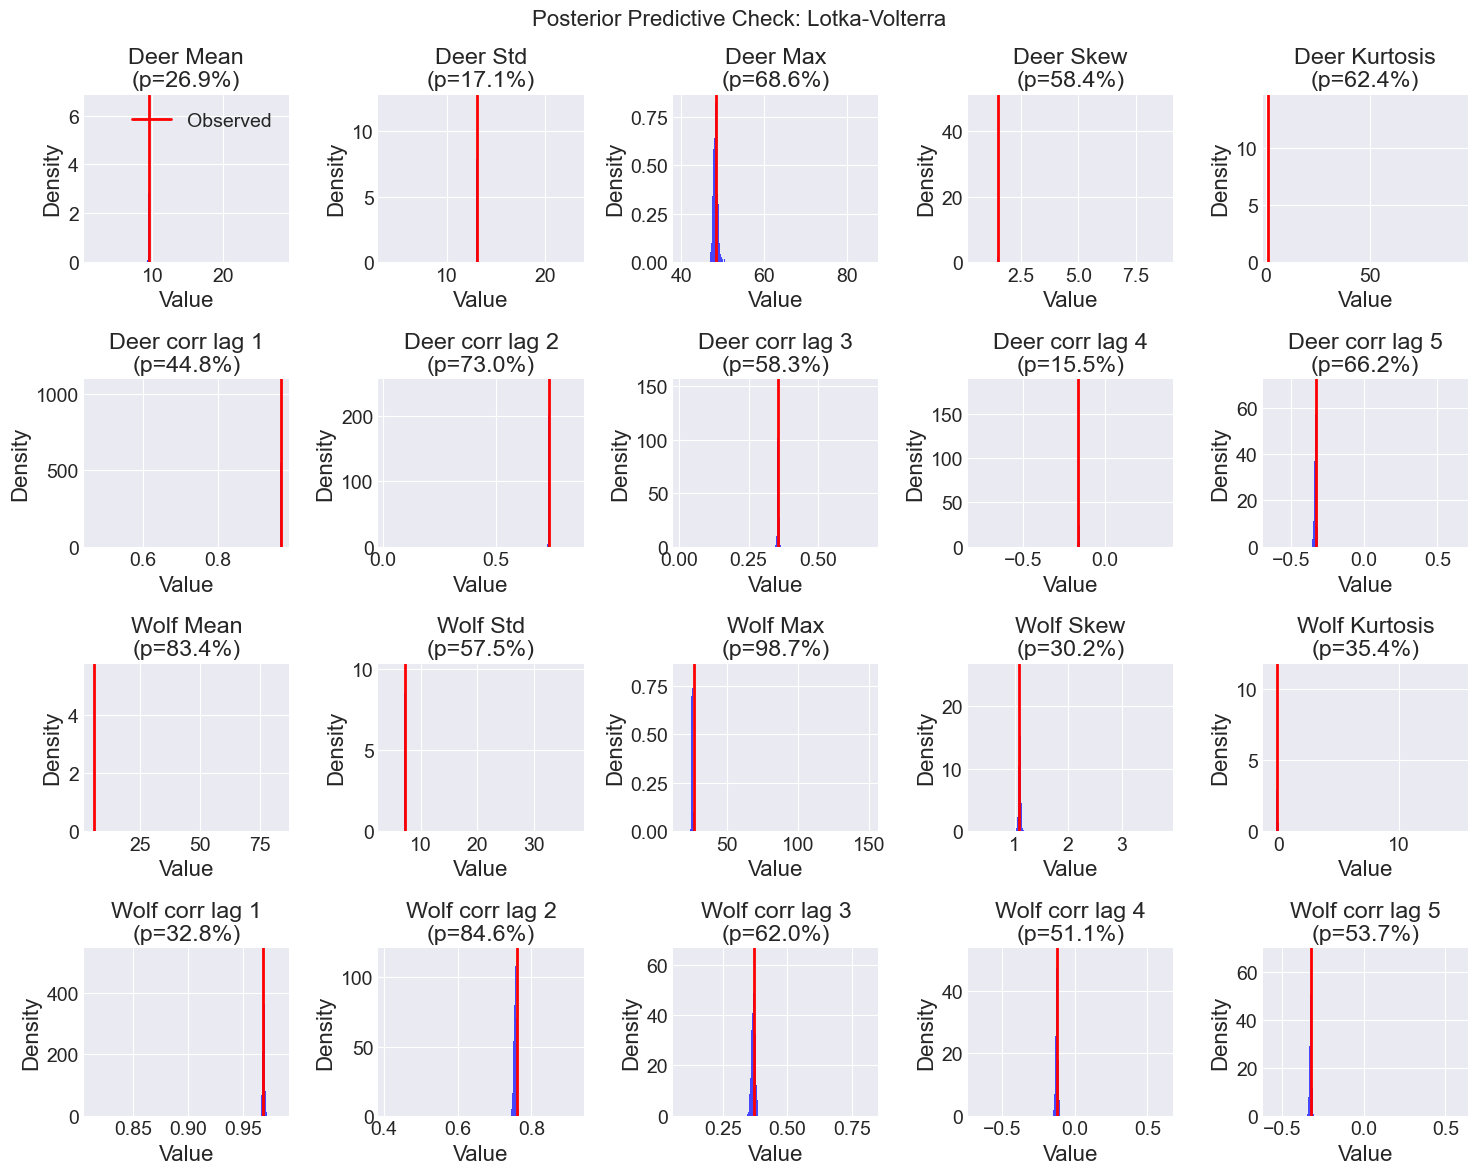


📊 Predictive Check Assessment:
----------------------------------------
⚠️ WARNING: Some observed statistics are in the tails of the distribution.
  1/20 statistics have extreme percentiles: ['98.7%']
   Consider if the model/prior might need adjustment.
🔴 Wolf Max: 98.7%


In [9]:
# Simulate data from the posterior.
num_predictive_sims = 1000
_, predictive_sims = simulate_for_sbi(
    lotka_volterra_simulator,
    posterior,
    num_simulations=num_predictive_sims,
    num_workers=num_workers,
)

# Visualize with prior predictive limits as bounds.
fig, ax = plot_predictive_check(
    predictive_sims,
    observed_data,
    stat_names=stat_names,
    limits=prior_data_limits,
    title="Posterior Predictive Check: Lotka-Volterra",
)

## Step 5: Simulation-Based Calibration (SBC)

**Key Question:** *When we say "90% confident", are we right 90% of the time?*

Before the environmental agency commits millions to conservation efforts, they need to
know: **Can we trust our uncertainty estimates?**

### What is SBC?
Simulation-Based Calibration tests whether our Bayesian credible intervals are
statistically reliable:

- **The Test**: We pretend to be nature 200+ times:
  1. Sample a "true" parameters from our prior
  2. Simulate fake observations with these parameters  
  3. Run inference to get a posterior
  4. Check: Does the posterior contain the truth?
  
- **Expected Result**: If our method works correctly:
  - 50% credible intervals should contain the truth ~50% of the time
  - 90% credible intervals should contain the truth ~90% of the time
  - The "rank" of true parameters should be uniformly distributed

### What Can Go Wrong?
SBC reveals different failure modes through the shape of the rank distribution:
- **∩-shaped** (underconfident): Posteriors too wide, like always saying "I don't know"
- **∪-shaped** (overconfident): Posteriors too narrow, false precision
- **Skewed**: Systematic bias in one direction

⚠️ **Important**: A perfect SBC doesn't mean perfect inference! You could pass SBC by
always returning the prior (maximally uncertain). That's why we combine SBC with
posterior predictive checks—to ensure we're both calibrated AND informative.

In [10]:
print("🎯 Diagnostic 5: Simulation-Based Calibration (SBC)")
print("=" * 50)
print("\n📊 The Ultimate Trust Test:")
print("   If we claim 90% confidence, are we right 90% of the time?")
print("\n🔬 Method: Running 200 'fake experiments' where we know the truth")
print("   For each: simulate data → run inference → check if truth is recovered")
print("\n⏱️  This may take a minute... (in practice, use 500+ tests)\n")

# Run SBC using sbi's built-in function
num_sbc_runs = 200
num_posterior_samples = 1000

thetas, xs = simulate_for_sbi(
    lotka_volterra_simulator,
    prior,
    num_simulations=num_sbc_runs,
    num_workers=num_workers,
)

print(f"Running {num_sbc_runs} SBC tests...")
ranks, dap_samples = run_sbc(
    thetas,
    xs,
    posterior,
    num_posterior_samples=num_posterior_samples,
    reduce_fns="marginals",
    use_batched_sampling=True,
)

🎯 Diagnostic 5: Simulation-Based Calibration (SBC)

📊 The Ultimate Trust Test:
   If we claim 90% confidence, are we right 90% of the time?

🔬 Method: Running 200 'fake experiments' where we know the truth
   For each: simulate data → run inference → check if truth is recovered

⏱️  This may take a minute... (in practice, use 500+ tests)



100%|██████████| 200/200 [00:00<00:00, 545.96it/s]


Running 200 SBC tests...


Drawing 1000 posterior samples: 1006it [00:47, 20.98it/s]                         
Calculating ranks for 200 sbc samples.: 100%|██████████| 200/200 [00:00<00:00, 19135.04it/s]


📈 Visualizing SBC Results: the empirical CDFs should lie inside the grey area.


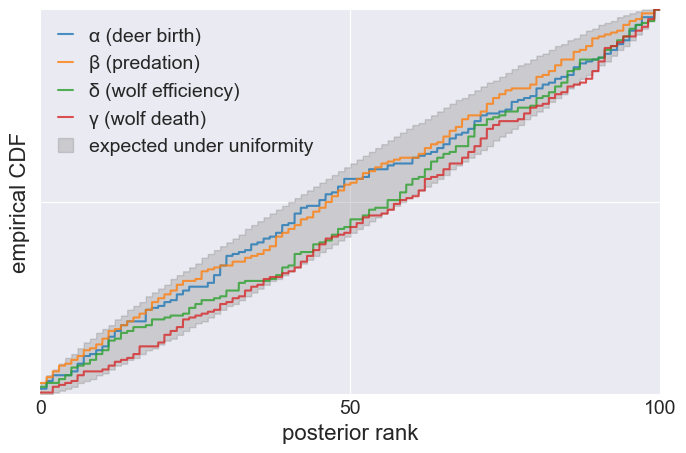

In [13]:
from sbi.analysis import sbc_rank_plot
from sbi.diagnostics import check_sbc

# Perform statistical checks on the SBC results.
ks_pvals, c2st_ranks, c2st_daps = check_sbc(ranks, thetas, dap_samples).values()

param_names = [
    "α (deer birth)",
    "β (predation)",
    "δ (wolf efficiency)",
    "γ (wolf death)",
]
param_names_short = ["α", "β", "δ", "γ"]

print("📈 Visualizing SBC Results: the empirical CDFs should lie inside the grey area.")
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples=num_posterior_samples,
    num_bins=100,
    parameter_labels=param_names,
    plot_type="cdf",
    ranks_labels=["Lotka-Volterra"],
)

In [14]:
print("\n📈 SBC Results per Parameter:")
print("=" * 40)

# Check each dimension
all_pass_ks = True
all_pass_c2st = True

for i, param in enumerate(param_names_short):
    ks_p = ks_pvals[i].item()
    c2st_r = c2st_ranks[i].item()

    ks_ok = ks_p > 0.05
    c2st_ok = 0.4 < c2st_r < 0.6

    all_pass_ks = all_pass_ks and ks_ok
    all_pass_c2st = all_pass_c2st and c2st_ok

    status = "✅" if (ks_ok and c2st_ok) else "⚠️"
    print(f"{status} {param}: KS p={ks_p:.3f}, C2ST={c2st_r:.3f}")

# Brief interpretation
print("\n🎯 Bottom Line:")
if all_pass_ks and all_pass_c2st:
    print("   ✅ All parameters well-calibrated!")
    print("   → Credible intervals are trustworthy")
else:
    flagged = [
        param_names_short[i]
        for i in range(4)
        if ks_pvals[i] <= 0.05 or c2st_ranks[i] >= 0.6
    ]
    print(f"   ⚠️  Calibration issues in: {', '.join(flagged)}")
    print("   → Review these parameters before decisions")


📈 SBC Results per Parameter:
✅ α: KS p=0.389, C2ST=0.550
✅ β: KS p=0.493, C2ST=0.487
✅ δ: KS p=0.098, C2ST=0.550
⚠️ γ: KS p=0.025, C2ST=0.520

🎯 Bottom Line:
   ⚠️  Calibration issues in: γ
   → Review these parameters before decisions


## 🎯 Key Takeaways

### Why Diagnostics Matter

1. **Neural networks can fail silently** - They might produce confident-looking but wrong results
2. **Not all posteriors are created equal** - Some might be overconfident, others too uncertain
3. **Trust but verify** - Always check your inference before making decisions
4. **Diagnostics catch different failures** - Each test reveals specific problems

### Your Diagnostic Toolkit

| Diagnostic | What it checks | Red flag | What it catches |
|------------|---------------|----------|-----------------|
| Prior Predictive | Prior covers observations | Observations in extreme tails | Bad prior specification |
| Training Diagnostics | Network convergence | Loss increasing or unstable | Insufficient training |
| Posterior Predictive | Can recreate observations | Observations outside CI | Too little or uninformative data |
| SBC | Calibrated credible intervals | Non-uniform rank histograms | Over/underconfident posteriors |

### Best Practices

✅ **Always run diagnostics** - Make it part of your workflow  
✅ **Start with the prior** - Bad prior → bad posterior  
✅ **Document results** - Keep diagnostic reports with your analysis  
✅ **Iterate if needed** - Poor diagnostics → adjust and retrain  

---

## 🚀 Challenge: Stress Testing

Try breaking the inference and seeing how diagnostics detect it:

1. **Too few simulations**: Retrain with only 500 simulations
2. **Wrong prior**: Use a prior that doesn't contain true parameters
3. **Corrupted data**: Add extreme outliers to observations

How do the diagnostics change? Which tests catch which problems?

In [ ]:
# Space for experimentation
